# Adsorption and Desorption of CO-Pd with Pyomo

Necessary imports

In [68]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.dae import *
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

Read in Data

In [69]:
# Area, Extinction Coefficient, Expected Coverage
co_pd_data = scipy.io.loadmat('../data/co_pd_data.mat')

In [70]:
# View headers
print(co_pd_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'area', 'cov_equilibrium', 'eps_equilibrium', 'eps_low_regions', 'time_area', 'tp_idx'])


In [71]:
# Areas and time variables
area = np.array(co_pd_data['area'][0])
time = np.array(co_pd_data['time_area'][0])

# Expected coverage at equilibrium
cov_eq = np.array(co_pd_data['cov_equilibrium'][0])

# Epsilong for low regions and epsilon for saturation regions
eps_low = np.array(co_pd_data['eps_low_regions'][0])
eps_eq = np.array(co_pd_data['eps_equilibrium'][0])

# Index when pressure is turned off
tp_idx = np.array(co_pd_data['tp_idx'][0])

Specify constant parameters and labels

In [72]:
# Number of temperature data sets
N = len(area)

# List of labels
temperatures = ['450', '460', '470', '475', '480', '490']

# Constants
P = 0.001  # Pressure of CO in the gas phase

# Measurement resolution
dt = 0.067

# Specify N distinguishing colors for plotting
colors = [
    (1.0, 0.498, 0.0),    # Orange
    (1.0, 0.749, 0.0),    # Light Orange
    (0.7, 0.5, 0),        # Dark Yellow
    (0.6, 0.7, 1.0),      # Light Blue
    (0.4, 0.4, 1.0),      # Medium Blue
    (0.0, 0.0, 1.0)       # Blue
]

# Estimated from prior literature and visual inspection in the latter figure
cut_off = 0.29

# Number of regions
R = 4

Pyomo requires working directly with the coverage.

We obtain the coverage deterministically through the area for each temperature based on the weighting assumption of the extinction coefficient described in the paper. In contrast, in our proposed approach we model this relationship probabilistically.

In [73]:
# Get coverage from area deterministically
cov = []
for n in range(N):
    A = area[n]
    w = A/max(A)
    eps_val = w*eps_eq[n] + (1-w)*eps_low[n]
    cov_temp = (A/eps_val)[0]
    # Manually set negative values to 0
    cov.append( [max(0,i) for i in cov_temp ])

Visualize Coverage Data

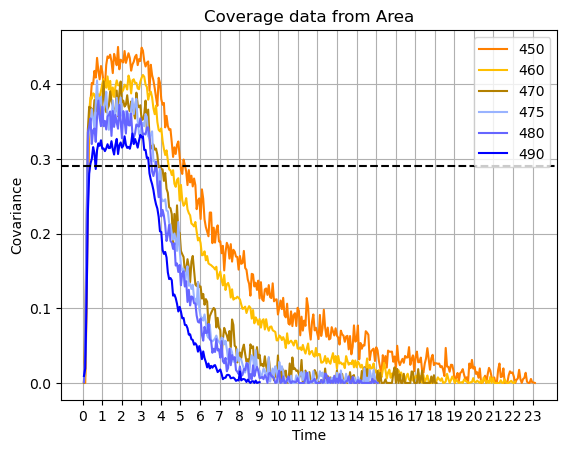

In [74]:
# Create a new figure
plt.figure()

# Plot coverage for all temperatures in one figure
for n in range(N):
    plt.plot(time[n], cov[n], color = colors[n])  # Plot the n-th pair with a label

plt.axhline(y=cut_off, color='black', linestyle='--')

# Formatting
plt.xlabel('Time') 
plt.ylabel('Covariance')  
plt.title('Coverage data from Area') 
plt.legend(temperatures)  
plt.grid(True)
plt.xticks(range(0, int(max(time[0])) + 1))

# Show the plot
plt.show()

### Pyomo Dynamic Optimization implementation

In [75]:
# We estimate the R3 to R4 split with the following time stamps for each temperature 
idx_split_R3 = []
time_cut_off_R3 = []
for n in range(N):
    indices = [i for i,c in enumerate(cov[n][tp_idx[0]:]) if c > cut_off]
    idx_split_R3.append(indices[-1]+tp_idx[0])
    time_cut_off_R3.append(float(time[n][idx_split_R3[-1]]))
    
# We estimate the R3 to R4 split with the following time stamps for each temperature 
idx_split_R1 = []
time_cut_off_R1 = []
for n in range(N):
    indices = [i for i,c in enumerate(cov[n][:tp_idx[0]]) if c < cut_off]
    idx_split_R1.append(indices[-1]+1)
    time_cut_off_R1.append(float(time[n][idx_split_R1[-1]]))

In [76]:
# Function for the solver - will be applied to R14 and R23 separately
def apply_pyomo_solver(timejoint, covjoint, idx_R1, dt, P, time1, cov1, time2, cov2):


    # Create the model
    model = ConcreteModel()

    # Define a discrete set for time points
    model.t = Set(initialize = timejoint)

    # Define the coverage variable, indexed by the discrete set
    model.coverage = Var(model.t, bounds=(0, 0.5))

    # Parameters to optimize: k1 and k2
    model.k1 = Var(bounds=(0, None), initialize=0.1)  # Desorption rate constant
    model.k2 = Var(bounds=(0, None), initialize=0.05)  # Adsorption rate constant

    # Define the Proposed Models
    def coverage_difference_rule(m, t):
        # Time jumps
        previous_time = t - dt 
        if previous_time in m.t:
            if previous_time > dt*tp_idx[0]:
                return m.coverage[t] == m.coverage[previous_time] -(m.k1 * m.coverage[previous_time]) * (t - previous_time)
            else:
                return m.coverage[t] == m.coverage[previous_time] + (m.k2 * P * (0.5 - m.coverage[previous_time]) - m.k1 * m.coverage[previous_time]) * (t - previous_time)
        else:
        #     # because our first time data point starts with dt not 0
             return Constraint.Skip
    model.coverage_eq = Constraint(model.t, rule=coverage_difference_rule)

    # Initial and boundary condition
    model.coverage[time1[0]].fix(max(cov1[0],0))
    model.coverage[time1[-1]].fix(cov1[-1])
    model.coverage[time2[0]].fix(cov2[0])
    model.coverage[time2[-1]].fix(max(cov2[-1],0))
    

    # Define least squares loss function
    def fit_coverage_rule(m):
        # (Fitted - Data)^2
        return sum((m.coverage[t] - covjoint[i])**2 for i, t in enumerate(m.t))  
    
    # Fit the model to the observed data
    model.obj = Objective(rule=fit_coverage_rule, sense=minimize)

    # Solve the model
    solver = SolverFactory('ipopt')
    solver.solve(model, tee=False)

    # Store the estimated rate constants per region
    k_des = model.k1.value
    k_ads = model.k2.value

    return [k_ads, k_des]

### REGIONS 1 and 4

In [77]:
# Region 1 and 4

# For fitted coverage
covR1 = []
covR4 = []

timeR1 = []
timeR4 = []

k_ads_R14 = []
k_des_R14 = []



# Get data
for n in range(N):

    #  Extract and Concatenate data for R1 and R4
    timeR1.append([i*dt for i in range(0,idx_split_R1[n]+1)])
    timeR4.append([i*dt for i in range(idx_split_R3[n] + 1,len(time[n]))])

    # Separate R1 and R4 coverage data
    covR1.append(list(cov[n][:idx_split_R1[n] + 1]))
    covR4.append(list(cov[n][idx_split_R3[n]+1:len(cov[n])+1]))

    # Concatenated coverage data R1 and R4
    covR14 = list(covR1[n]) + list(covR4[n])
    timeR14 = timeR1[n] + timeR4[n]

    # Apply Solver
    k_ads14, k_des14 = apply_pyomo_solver(timeR14, covR14, idx_split_R1[n], dt, P, timeR1[n], covR1[n], timeR4[n], covR4[n])

    # Store rate constants for each temp
    k_ads_R14.append(k_ads14)
    k_des_R14.append(k_des14)


### REGIONS 2 and 3

In [78]:
# Region 2 and 3

# For fitted coverage
timeR2 = []
timeR3 = []

covR2 = []
covR3 = []

k_ads_R23 = []
k_des_R23 = []

# Get data
for n in range(N):

    #  Extract and Concatenate data for R2 and R3
    timeR2.append([i*dt for i in range(idx_split_R1[n]+1,tp_idx[0])])
    timeR3.append([i*dt for i in range(tp_idx[0]+1, idx_split_R3[n]+1)])

    # Separate R1 and R4 coverage data
    covR2.append(list(cov[n][idx_split_R1[n]+1:tp_idx[0]]))
    covR3.append(list(cov[n][tp_idx[0]+1 : idx_split_R3[n]+1]))

    # Concatenated coverage data R2 and R3
    covR23 = covR2[n] + covR3[n]
    timeR23 = timeR2[n] + timeR3[n]

    # Apply Solver
    k_ads23, k_des23 = apply_pyomo_solver(timeR23, covR23, idx_split_R1[n], dt, P, timeR2[n], covR2[n], timeR3[n], covR3[n])

    # Store rate constants
    k_ads_R23.append(k_ads23)
    k_des_R23.append(k_des23)

    


Organize and save rate constants

In [79]:
k = [k_ads_R14, k_ads_R23, k_des_R23, k_des_R14]
scipy.io.savemat('../data/k_pyomo.mat', {'k': k})

In [80]:
table = [[f'{k[r][n]}' for r in range(4)] for n in range(6)]

# Print the table to see the result
for n in range(N):
    print(temperatures[n], 'K: Adsorption k_ads =  ', table[n][:2], '    Desorption k_des = ', table[n][2:])


450 K: Adsorption k_ads =   ['3624.8324368364033', '1942.0866010884288']     Desorption k_des =  ['0.11837497610470794', '0.0967172086652623']
460 K: Adsorption k_ads =   ['4249.088977483452', '1316.5985433688904']     Desorption k_des =  ['0.3357989651259281', '0.14249617015094915']
470 K: Adsorption k_ads =   ['4843.678161433913', '723.7687035769312']     Desorption k_des =  ['0.28643329112037275', '0.24944157970695122']
475 K: Adsorption k_ads =   ['4574.620440867629', '2321.2004916200335']     Desorption k_des =  ['0.7584596619064521', '0.430495672607345']
480 K: Adsorption k_ads =   ['4724.9565618499755', '108.18913053755332']     Desorption k_des =  ['0.12500268761243075', '0.2044893396263209']
490 K: Adsorption k_ads =   ['2478.545215869929', '329.4829522314082']     Desorption k_des =  ['0.20172503496452004', '1.2905178112544606']
